In [1]:
import scanpy as sc 
import pandas as pd
import numpy as np
import os
import sys
import pickle
import commot as ct

In [ ]:
sample = 2
adata_path = f'/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph{sample}_ctrl_visiumHD.h5ad'
# adata_path = f'/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/mouse_lymph{sample}_ctrl_visiumHD.h5ad'
adata = sc.read(adata_path)
adata

In [ ]:
adata.X = adata.layers['normalized_count'].copy()

import gc
del adata.layers
gc.collect()

adata

In [ ]:
df_ligrec = ct.pp.ligand_receptor_database(
    database='CellChat', 
    species='mouse', 
    signaling_type=None
)
    
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  

df_ligrec['name'] = df_ligrec['ligand'] + '-' + df_ligrec['receptor']
len(df_ligrec['name'].unique())

2017

In [ ]:
import sys
sys.path.append('../../src')
from spaceoracle.tools.network import expand_paired_interactions

expanded = expand_paired_interactions(df_ligrec)
genes = set(expanded.ligand) | set(expanded.receptor)
genes = list(genes)

expanded

,ligand,receptor,pathway,signaling,name
0,Tgfb1,Tgfbr1,TGFb,Secreted Signaling,Tgfb1-Tgfbr1_Tgfbr2
0,Tgfb1,Tgfbr2,TGFb,Secreted Signaling,Tgfb1-Tgfbr1_Tgfbr2
1,Tgfb2,Tgfbr1,TGFb,Secreted Signaling,Tgfb2-Tgfbr1_Tgfbr2
1,Tgfb2,Tgfbr2,TGFb,Secreted Signaling,Tgfb2-Tgfbr1_Tgfbr2
2,Tgfb3,Tgfbr1,TGFb,Secreted Signaling,Tgfb3-Tgfbr1_Tgfbr2
...,...,...,...,...,...
2016,Itga9,Vcam1,VCAM,Cell-Cell Contact,Itga9_Itgb1-Vcam1
2016,Itgb1,Vcam1,VCAM,Cell-Cell Contact,Itga9_Itgb1-Vcam1
2017,Itga4,Vcam1,VCAM,Cell-Cell Contact,Itga4_Itgb7-Vcam1
2017,Itgb7,Vcam1,VCAM,Cell-Cell Contact,Itga4_Itgb7-Vcam1


In [ ]:
expanded = expanded[expanded.ligand.isin(adata.var_names) & expanded.receptor.isin(adata.var_names)]
expanded

,ligand,receptor,pathway,signaling,name
0,Tgfb1,Tgfbr1,TGFb,Secreted Signaling,Tgfb1-Tgfbr1_Tgfbr2
0,Tgfb1,Tgfbr2,TGFb,Secreted Signaling,Tgfb1-Tgfbr1_Tgfbr2
3,Tgfb1,Acvr1b,TGFb,Secreted Signaling,Tgfb1-Acvr1b_Tgfbr2
3,Tgfb1,Tgfbr2,TGFb,Secreted Signaling,Tgfb1-Acvr1b_Tgfbr2
4,Tgfb1,Tgfbr2,TGFb,Secreted Signaling,Tgfb1-Acvr1c_Tgfbr2
...,...,...,...,...,...
2015,Itga4,Vcam1,VCAM,Cell-Cell Contact,Itga4_Itgb1-Vcam1
2015,Itgb1,Vcam1,VCAM,Cell-Cell Contact,Itga4_Itgb1-Vcam1
2016,Itgb1,Vcam1,VCAM,Cell-Cell Contact,Itga9_Itgb1-Vcam1
2017,Itga4,Vcam1,VCAM,Cell-Cell Contact,Itga4_Itgb7-Vcam1


In [ ]:
# COMMOT keeps running out of memory (and is taking forever), so we will make overlapping crops
# and run COMMOT on each tile, taking the superset of all LRs identified 

In [8]:
import napari
viewer = napari.Viewer()

coords = adata.obsm['spatial']
spatial_coords = viewer.add_points(coords, size=10, face_color='blue', name='spatial')

In [ ]:
# tmp_dir = '/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/control/commot'
tmp_dir = '/ix3/djishnu/alw399/visiumHD_lymph/control/commot'

In [ ]:
tiles = viewer.layers['tiles']
np.savez(f'{tmp_dir}/lymph{sample}_COMMOT_tiles.npz', tiles=tiles.data)

In [ ]:
tiles = np.load(f'{tmp_dir}/lymph{sample}_COMMOT_tiles.npz')['tiles']
coords = adata.obsm['spatial']

import easydict
tiles = easydict.EasyDict({'data': tiles})

In [ ]:
import math

def box_to_circle(box_coords):
    x_coords, y_coords = zip(*box_coords)
    center_x = np.mean(x_coords)
    center_y = np.mean(y_coords)

    corner_x, corner_y = box_coords[0]  # We can use any corner, here I use the first corner
    radius = math.sqrt((center_x - corner_x) ** 2 + (center_y - corner_y) ** 2)
    
    return (center_x, center_y, radius)

def points_in_circle(center, radius, points):
    return np.array([pt for pt in points if math.sqrt((pt[0] - center[0]) ** 2 + (pt[1] - center[1]) ** 2) <= radius])

tile_coords = {}
for tile_idx, box_coords in enumerate(tiles.data):
    center_x, center_y, radius = box_to_circle(box_coords)
    subset_coords = points_in_circle((center_x, center_y), radius, coords)
    if len(subset_coords) == 0:
        continue
    tile_coords[len(tile_coords)] = subset_coords

len(tile_coords)


22

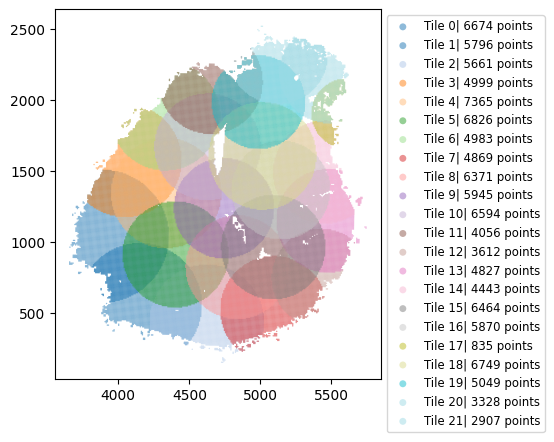

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

cmap = cm.get_cmap('tab20', len(tile_coords))
colors = [cmap(i) for i in range(len(tile_coords))]

for tile_idx, subset_coords in tile_coords.items():
    plt.scatter(
        subset_coords[:, 0], subset_coords[:, 1], 
        s=1, color=colors[tile_idx],
        alpha=0.5, edgecolor='none', 
        label=f'Tile {tile_idx}| {len(subset_coords)} points'
    )

plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', markerscale=5)
plt.show()

In [ ]:
viewer.close()

In [ ]:
coords_lookup = pd.DataFrame(
    adata.obs_names,
    index = [f'{x}-{y}' for x, y in adata.obsm['spatial']],
    columns=['barcode']
)
coords_lookup.head(2)

,barcode
5570.589829699587-1318.1431085668607,s_008um_00584_00158-1
5113.704855336519-789.6363229921634,s_008um_00651_00214-1


In [ ]:
%%time
adata_coords = tile_coords[0]
barcodes = coords_lookup.loc[[f'{x}-{y}' for x, y in adata_coords]].barcode
adata_subset = adata[barcodes]

print(adata_subset)

ct.tl.spatial_communication(adata_subset,
    database_name='user_database', 
    # df_ligrec=df_ligrec, 
    df_ligrec=expanded, 
    dis_thr=200, 
    # heteromeric=True
    heteromeric=False
)

View of AnnData object with n_obs × n_vars = 6674 × 3038
    obs: 'cell_type', 'cell_type_int', 'sample'
    uns: 'cell_type_colors'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'


: 

In [ ]:
from tqdm import tqdm

for tile_idx, adata_coords in tqdm(tile_coords.items(), total=len(tile_coords)):

    if tile_idx == 0:
        continue

    barcodes = coords_lookup.loc[[f'{x}-{y}' for x, y in adata_coords]].barcode
    adata_subset = adata[barcodes]

    ct.tl.spatial_communication(adata_subset,
        database_name='user_database', 
        # df_ligrec=df_ligrec, 
        df_ligrec=expanded, 
        dis_thr=200, 
        # heteromeric=True
        heteromeric=False
    )

    adata_subset.write(f'{tmp_dir}/lymph{sample}_COMMOT_tile{tile_idx}.h5ad')


  0%|          | 0/22 [00:00<?, ?it/s]

: 

### Get cluster communication scores

In [ ]:
expanded['rename'] = expanded['ligand'] + '-' + expanded['receptor']

In [ ]:
from tqdm import tqdm
import commot as ct

for name in tqdm(expanded['rename'].unique()):

    ct.tl.cluster_communication(adata, database_name='user_database', pathway_name=name, clustering='cell_type',
        random_seed=12, n_permutations=100)

In [ ]:
from collections import defaultdict
data_dict = defaultdict(dict)

for name in expanded['rename']:
    data_dict[name]['communication_matrix'] = adata.uns[f'commot_cluster-cell_type-user_database-{name}']['communication_matrix']
    data_dict[name]['communication_pvalue'] = adata.uns[f'commot_cluster-cell_type-user_database-{name}']['communication_pvalue']

import pickle
with open(f'/ix/djishnu/shared/djishnu_kor11/commot_outputs/commot_mouse_lymph{sample}_communication.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

In [ ]:
import pickle
with open(f'/ix/djishnu/shared/djishnu_kor11/commot_outputs/commot_mouse_lymph{sample}_communication.pkl', 'rb') as f:
    info = pickle.load(f)

len(info.keys())

In [ ]:
def get_sig_interactions(value_matrix, p_matrix, pval=0.3):
    p_matrix = np.where(p_matrix < pval, 1, 0)
    return value_matrix * p_matrix

interactions = {}
for lig, rec in tqdm(zip(expanded['ligand'], expanded['receptor'])):
    name = lig + '-' + rec

    if name in info.keys():

        value_matrix = info[name]['communication_matrix']
        p_matrix = info[name]['communication_pvalue']

        sig_matrix = get_sig_interactions(value_matrix, p_matrix)
        
        if sig_matrix.sum().sum() > 0:
            interactions[name] = sig_matrix
    
len(interactions)

### Get expanded LR masks

In [ ]:
interactions.keys()

In [ ]:
# create cell x gene matrix
ct_masks = {ct: adata.obs['cell_type'] == ct for ct in adata.obs['cell_type'].unique()}

df = pd.DataFrame(index=adata.obs_names, columns=genes)
df = df.fillna(0)

for name in tqdm(interactions.keys(), total=len(interactions)):
    lig, rec = name.rsplit('-', 1)
    
    tmp = interactions[name].sum(axis=1)
    for ct, val in zip(interactions[name].index, tmp):
        df.loc[ct_masks[ct], lig] += tmp[ct]
    
    tmp = interactions[name].sum(axis=0)
    for ct, val in zip(interactions[name].columns, tmp):
        df.loc[ct_masks[ct], rec] += tmp[ct]

df.shape

In [ ]:
print('Number of LR filtered using celltype specificity:')
np.where(df > 0, 1, 0).sum().sum() / (df.shape[0] * df.shape[1])

In [ ]:
cell_threshes = df

### Save params in adata

In [ ]:
import sys 
sys.path.append('../../src')
from spaceoracle.models.parallel_estimators import *

adata.uns['cell_thresholds'] = cell_threshes
adata

In [ ]:
adata = init_received_ligands(
    adata, 
    radius=100, 
    contact_distance=30, 
    cell_threshes=cell_threshes
)
adata

In [ ]:
adata.write_h5ad(adata_path)
